In [7]:
import numpy as np
import pandas as pd
import random
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
Data = pd.read_csv('/Users/mac/Desktop/Project1/df.csv')
Test = pd.read_csv('/Users/mac/Desktop/Project1/test.csv')

In [3]:
print(Data)
#24004361 rows x 2 columns

           node_1   node_2
0          540762  1912140
1          540762  1537559
2          540762  3091331
3          540762  2757277
4          540762  3237295
...           ...      ...
24004356  3547024  1075576
24004357  3547024  4549841
24004358  3547024  1135647
24004359  3547024   807274
24004360  3547024  3897045

[24004361 rows x 2 columns]


In [18]:
#source = list(Test.source)
#source
#sink = list(Test.sink)
#node_test = (source,sink)
#node_test = np.array((source,sink)))
node_test = np.array(Test[['source','sink']])
node_test

node_train = np.array(Data[['node_1','node_2']])
node_train

array([[ 540762, 1912140],
       [ 540762, 1537559],
       [ 540762, 3091331],
       ...,
       [3547024, 1135647],
       [3547024,  807274],
       [3547024, 3897045]])

In [5]:
#Data.head()
Test.head()

,Id,source,sink
0,1,3563811,3600160
1,2,2052043,1401960
2,3,4517994,1690636
3,4,1660006,4349447
4,5,581111,1882617


In [6]:
DG = nx.from_pandas_edgelist(Data, "node_1", "node_2", create_using=nx.DiGraph())

In [22]:
TG = nx.from_pandas_edgelist(Test, "source", "sink", create_using=nx.DiGraph())

In [9]:
#random nodes

random.seed(0)
num = random.sample(range(0,4867135),400000)
num_uni = set(num)
len(num_uni)

400000

In [19]:
split = np.array(num).reshape(200000,2)
df= pd.DataFrame(split)
df.columns = ['from','in']
split

array([[3231671, 3528010],
       [ 339607, 2171951],
       [4288883, 4076256],
       ...,
       [ 147065,  511531],
       [2946804, 4291785],
       [4458701, 2054908]])

In [38]:
label = []

for node in split:
    a = node[0]
    b = node[1]
    
    if DG.has_edge(a,b):
        label.append(1)
    elif TG.has_edge(a,b):
        label.append(-1)
    else:
        label.append(0)

In [40]:
set(label) #all posible nagetive ones

{0}

In [42]:
df['label'] = label
df.head()

,from,in,label
0,3231671,3528010,0
1,339607,2171951,0
2,4288883,4076256,0
3,3396833,2544371,0
4,3997985,3003535,0


In [49]:
#Tversky Index, unbalanced and adjustable

def TverskyInd (node_a, node_b, w):
    a_out_set = set(DG.successors(node_a))
    b_out_set = set(DG.successors(node_b))
    
    if len(a_out_set | b_out_set):
        common = len(a_out_set & b_out_set)
        sub_1 = len(a_out_set - b_out_set)
        sub_2 = len(b_out_set - a_out_set)
        index = common / (common + w*sub_1 + (1-w)*sub_2)
        return index
    else:
        return -1


In [50]:
w = 0.75 #the weight
Sim = []

for node in split:
    node_a = node[0]
    node_b = node[1]
    temp = TverskyInd (node_a, node_b, w)
    Sim.append(temp)

In [52]:
set(Sim)

{-1, 0.0, 0.004393190554640308, 0.0045662100456621}

In [54]:
Sim_np = np.array(Sim)
len(Sim_np[Sim_np==0]) #1635
len(Sim_np[Sim_np>0]) #2

2

In [57]:
#Jaccard Index Sim

def CaculateSim (node_a, node_b):
    a_in_set = set(DG.predecessors(node_a))
    a_out_set = set(DG.successors(node_a))
    
    b_in_set = set(DG.predecessors(node_b))
    b_out_set = set(DG.successors(node_b))
    
    a_b_all = set(a_in_set | a_out_set | b_in_set | b_out_set)
    s1 = len(a_in_set & b_in_set)
    s2 = len(a_out_set & b_out_set)
    s3 = len(a_in_set & b_out_set)
    s4 = len(a_out_set & b_in_set)
    a_b_same = s1+s2+s3+s4
    
    if len(a_b_all):
        sim = a_b_same / (2*len(a_b_all))
        return sim
    else:
        return -1

In [58]:
Sim_ja = []

for node in split:
    node_a = node[0]
    node_b = node[1]
    temp = CaculateSim (node_a, node_b)
    Sim_ja.append(temp)

In [139]:
ja = np.array(Sim_ja)
len(ja[ja == 0]) #186180
len(ja[ja > 0]) #13820
len(ja[ja < 0]) #0

200000

In [72]:
# Ath is the authority value of node

ath = []

for node in split:
    node_a = node[0]
    node_b = node[1]
    
    pre = set(DG.predecessors(node_b))
    ath.append(len(pre))  

In [73]:
len(ath) #2000

200000

In [74]:
hub = []

for node in split:
    node_a = node[0]
    node_b = node[1]
    
    suc = set(DG.successors(node_a))
    hub.append(len(suc))

In [75]:
len(hub)

200000

In [78]:
max(ath)#2035
max(hub)#509445

509445

In [83]:
ath_adj = np.array(ath).astype(float)/2035
hub_adj = np.array(hub).astype(float)/509445

In [146]:
min(ath_adj)

0.0004914004914004914

In [136]:
comb = pd.DataFrame({'sim':ja, 'ath': ath_adj, 'hub':hub_adj})
comb[comb['sim'] < 0]

,sim,ath,hub


In [89]:
value = np.array(comb[['sim','ath','hub']])
value

array([[0.16666667, 0.0004914 , 0.        ],
       [0.        , 0.0004914 , 0.        ],
       [0.        , 0.0004914 , 0.        ],
       ...,
       [0.        , 0.0009828 , 0.        ],
       [0.        , 0.0009828 , 0.        ],
       [0.        , 0.0004914 , 0.        ]])

In [97]:
prob = []

for node in value:
    sim = node[0]
    ath = node[1]
    hub = node[2]
    temp = (sim + ath + hub)*10000
    
    prob.append(temp)

In [98]:
sum(prob)/len(prob)

149.77205611250753

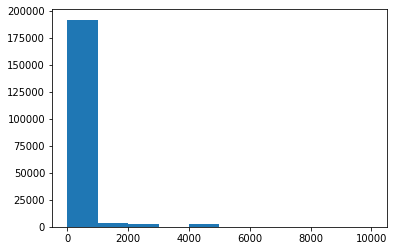

In [124]:
plt.hist(prob)
plt.show()

In [147]:
prob_adj = np.array(prob)
#prob_adj[prob_adj>1000] = 100
len(prob_adj[prob_adj<4.92]) #112175

112175

In [151]:
df['pro'] = prob_adj
df.head()
a = df[df['label']==0]
b = df[df['pro']<4.92]

,from,in,label,pro
1,339607,2171951,0,4.914005
2,4288883,4076256,0,4.914005
3,3396833,2544371,0,4.914005
4,3997985,3003535,0,4.914005
5,1832430,4233620,0,4.914005
...,...,...,...,...
199990,4278560,3490599,0,4.914005
199991,238920,1784678,0,4.914005
199992,4541074,2765794,0,4.914005
199994,705763,3068025,0,4.914005


In [154]:
pre = b[['from','in','label']]
pre

,from,in,label
1,339607,2171951,0
2,4288883,4076256,0
3,3396833,2544371,0
4,3997985,3003535,0
5,1832430,4233620,0
...,...,...,...
199990,4278560,3490599,0
199991,238920,1784678,0
199992,4541074,2765794,0
199994,705763,3068025,0


In [155]:
pre.to_csv('/Users/mac/Desktop/Project1/negative.csv', index = False, header = True)

In [159]:
nage = pd.read_csv('/Users/mac/Desktop/Project1/negative.csv')
nage

,from,in,label
0,339607,2171951,0
1,4288883,4076256,0
2,3396833,2544371,0
3,3997985,3003535,0
4,1832430,4233620,0
...,...,...,...
112170,4278560,3490599,0
112171,238920,1784678,0
112172,4541074,2765794,0
112173,705763,3068025,0


In [171]:
random.seed(912)
indx = random.sample(range(0,112174),1000)
nage_sub = nage.loc[indx]
nage_sub

,from,in,label
68990,4439072,651480,0
97162,3935739,217423,0
40713,2255423,846224,0
24732,4188068,2343260,0
73405,3674813,1823397,0
...,...,...,...
14241,4258976,890540,0
73768,2490312,3420758,0
44071,2228651,3594228,0
28368,3248588,194879,0


In [179]:
Data
random.seed(1001)
indx = random.sample(range(0,24004360),10000)
posi_sub = Data.loc[indx]
posi_sub['label'] = 1
posi_sub.columns = ['from','in','label']
posi_sub #1967169
data_part = Data.drop(index=Data.loc[indx].index)
data_part #24004361 rows to 23994361

,node_1,node_2
0,540762,1912140
1,540762,1537559
2,540762,3091331
3,540762,2757277
4,540762,3237295
...,...,...
24004356,3547024,1075576
24004357,3547024,4549841
24004358,3547024,1135647
24004359,3547024,807274


In [180]:
posi_sub

,from,in,label
1967169,474172,1744210,1
6644985,2290451,322560,1
3062648,2962038,828994,1
18642666,3759853,3142018,1
12660341,2950311,3482768,1
...,...,...,...
15767264,946157,896124,1
6872458,2206273,331934,1
8713922,3671141,4623715,1
16209164,3183734,1550240,1


In [174]:
sample = posi_sub.append(nage_sub)
sample

,from,in,label
1967169,474172,1744210,1
6644985,2290451,322560,1
3062648,2962038,828994,1
18642666,3759853,3142018,1
12660341,2950311,3482768,1
...,...,...,...
14241,4258976,890540,0
73768,2490312,3420758,0
44071,2228651,3594228,0
28368,3248588,194879,0


In [175]:
sample.to_csv('/Users/mac/Desktop/Project1/train_sample.csv', index = False, header = True)

In [181]:
data_part.to_csv('/Users/mac/Desktop/Project1/partial.csv', index = False, header = True)